### TODO
- Manage NA values
- Manage useless features
    - `year` : merge with name
    - `link`, `logo` : delete
- Looking for strange values
    - score_i > score_j && rank_i > rank_j
- Using pandas categories
    - `country`, `city`, `region`
    - `type`, `size`, `research_ouptut`
- Looking for correlation between features
- Calculate rank for values with score but no rank (Temporarily dropped rows with no rank)


### Rapport du prof
- Tester différentes métriques
- Modèles à utiliser :
    - Linear model 
    - XGBoost ++
    - Decision tree
- Visualiser les données (matrice de corrélation)



# Projet de session

## QS World University Rankings (2017 to 2022)

(Noms)

### Notebook settings and imports

In [847]:
import numpy as np

import pandas as pd
from pandas.api.types import is_object_dtype, is_numeric_dtype

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import tree
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics

from xgboost import XGBClassifier
from xgboost import XGBRegressor

### Loading data

In [848]:
data_init = pd.read_csv("qs-world-university-rankings-2017-to-2022-V2.csv")
N_init, D_init = data_init.shape
data_init.head()

,university,year,rank_display,score,link,country,city,region,logo,type,research_output,student_faculty_ratio,international_students,size,faculty_count
0,Massachusetts Institute of Technology (MIT),2017,1,100.0,https://www.topuniversities.com/universities/m...,United States,Cambridge,North America,https://www.topuniversities.com/sites/default/...,Private,Very High,4.0,"3,730",M,"3,065"
1,Stanford University,2017,2,98.7,https://www.topuniversities.com/universities/s...,United States,Stanford,North America,https://www.topuniversities.com/sites/default/...,Private,Very High,3.0,"3,879",L,"4,725"
2,Harvard University,2017,3,98.3,https://www.topuniversities.com/universities/h...,United States,Cambridge,North America,https://www.topuniversities.com/sites/default/...,Private,Very High,5.0,"5,877",L,"4,646"
3,University of Cambridge,2017,4,97.2,https://www.topuniversities.com/universities/u...,United Kingdom,Cambridge,Europe,https://www.topuniversities.com/sites/default/...,Public,Very high,4.0,"7,925",L,"5,800"
4,California Institute of Technology (Caltech),2017,5,96.9,https://www.topuniversities.com/universities/c...,United States,Pasadena,North America,https://www.topuniversities.com/sites/default/...,Private,Very High,2.0,692,S,968


In [849]:
data_init.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6482 entries, 0 to 6481
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   university              6482 non-null   object 
 1   year                    6482 non-null   int64  
 2   rank_display            6414 non-null   object 
 3   score                   2820 non-null   float64
 4   link                    6482 non-null   object 
 5   country                 6482 non-null   object 
 6   city                    6304 non-null   object 
 7   region                  6482 non-null   object 
 8   logo                    6482 non-null   object 
 9   type                    6470 non-null   object 
 10  research_output         6480 non-null   object 
 11  student_faculty_ratio   6407 non-null   float64
 12  international_students  6318 non-null   object 
 13  size                    6480 non-null   object 
 14  faculty_count           6404 non-null   

### Clean-up : useless features

In [850]:
# Drop useless columns
useless_columns = [
    "link",
    "logo"
]
data = data_init.drop(columns=useless_columns, axis=1)

### Managing few columns

In [851]:
# Merge year with university's name

university_with_year = data["university"] + data["year"].map(" ({})".format)
data.insert(0, "university_with_year", university_with_year)

In [852]:
# In rank, replace N-M with N
rank_display_raw = data["rank_display"].map(lambda rank: str(rank).split("-")[0], na_action='ignore')
rank_display_raw = rank_display_raw.fillna(0)  # pour pouvoir convertir en entier
rank_display_raw = rank_display_raw.astype('int')

data.insert(4, "rank_display_raw", rank_display_raw)
data["rank_display_raw"] = data['rank_display_raw'].replace(0, np.nan)

In [853]:
# Creating new feature for classification
data["class"] = [rank//100 for rank in data["rank_display_raw"]]

In [854]:
# international_students and faculty_count are integers written as strings
for col in ("international_students", "faculty_count"):
    if is_object_dtype(data[col]):
        data[col] = data[col].str.replace(',', '')
        data[col] = data[col].str.replace('.', '')
        data[col] = pd.to_numeric(data[col], errors='coerce')

C:\Users\Josse\AppData\Local\Temp\ipykernel_17948\2436347002.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data[col] = data[col].str.replace('.', '')


### Converting objects to categorical

In [855]:
# In some columns different caps lead to different categories
# So before assigning categories everything is lowercased
for col in data.columns:
    if is_object_dtype(data[col]):
        data[col] = data[col].str.lower()
        data[col] = data[col].astype('category')
        data[col] = data[col].cat.codes + 1

### Analysing Missing Values

number of NAs by column: 
number/proportion of cells with missing values: 4115 / 0.04
number/proportion of rows with NAs: 3703 / 0.57


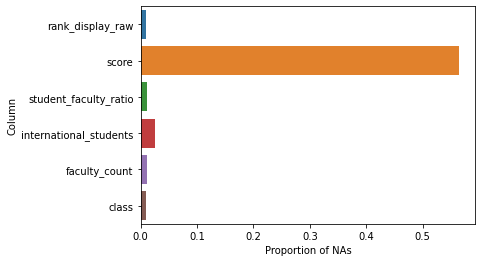

In [856]:
total_init_nas = data.isna().sum().sum()

print("number of NAs by column: ")
nas_by_cols = data.isna().sum()[data.isna().sum() > 0]
nas_by_cols = pd.DataFrame({"Column": nas_by_cols.index, "Number of NAs": nas_by_cols})
nas_by_cols["Proportion of NAs"] = nas_by_cols["Number of NAs"] / len(data)

sns.barplot(
    y="Column",
    x="Proportion of NAs",
    data=nas_by_cols
)

nb_missing_values = data.isna().sum().sum()
prop_missing_values = nb_missing_values / (nb_missing_values + data.count().sum())
print(f"number/proportion of cells with missing values: {nb_missing_values} / {prop_missing_values:0.2f}")


nb_rows_with_na = data.isna().any(axis=1).sum()
prop_rows_with_na = nb_rows_with_na / N_init
print(f"number/proportion of rows with NAs: {nb_rows_with_na} / {prop_rows_with_na:0.2f}")

### Clean-up : NA values

* Filling the `score`

In [857]:
def fill_score_if_possible():
    """
    Check by year:
        - Group by ranks
        - Check for a value somewhere
        - Fill columns with the mean of the values found
    """

    years = data["year"].unique()
    
    for year in years:
        # Check by year
        data_year = data.loc[data["year"] == year]

        ranks = data_year["rank_display"].unique()
        for rank in ranks:
            # Group by ranks
            data_year_rank = data_year.loc[data["rank_display"] == rank]

            # If there's equalities, check for a missing value
            # If there is one, fill by the mean of the other values
            if data_year_rank.shape[0] > 1:
                data_year_rank_scores = data_year_rank["score"]
                if data_year_rank_scores.isna().sum() > 0:
                    data.loc[
                        (data["year"] == year) & (data["rank_display"] == rank),
                        "score"
                    ] = data_year_rank_scores.mean()
            

init_nb_scores_na = data["score"].isna().sum()
fill_score_if_possible()
new_nb_scores_na = data["score"].isna().sum()

nb_filled_scores = init_nb_scores_na - new_nb_scores_na
prop_filled = nb_filled_scores / len(data)
print(f"number/proportion of rows filled: {nb_filled_scores} / {prop_filled:0.2f}")

number/proportion of rows filled: 183 / 0.03


* Filling numeric columns (`student_faculty_ratio`, `international_students` and `faculty_count`)

In [858]:
# Filling some missing values with the median of the values from the same class
def fill_with_median(columns_to_fill):
    for col in columns_to_fill:
        data[col] = data[col].fillna(data.groupby('class')[col].transform('median'))

init_nb_numerics_na = data[["student_faculty_ratio", "international_students", "faculty_count"]].isna().sum().sum()

columns_to_fill = ["student_faculty_ratio", "international_students", "faculty_count"]
fill_with_median(columns_to_fill)

new_nb_numerics_na = data[["student_faculty_ratio", "international_students", "faculty_count"]].isna().sum().sum()

nb_filled_numerics = init_nb_numerics_na - new_nb_numerics_na
prop_filled = nb_filled_scores / len(data)
print(f"number/proportion of rows filled: {nb_filled_numerics} / {prop_filled:0.2f}")

number/proportion of rows filled: 211 / 0.03


* Deleting the other rows

In [859]:
def delete_rows_with_too_much_na(max_na_count):
    data_with_na = data.loc[data.isna().any(axis=1)]
    data_count_na_by_row = data_with_na.isna().sum(axis=1)
    data_count_na_by_row.sort_values(ascending=False)
    
    data_with_too_much_na_idxs = data_count_na_by_row.loc[data_count_na_by_row >= max_na_count].index
    data.drop(data_with_too_much_na_idxs, inplace=True)

init_nb_na = data.isna().sum().sum()
init_len = len(data)

max_na_count = 2
delete_rows_with_too_much_na(max_na_count)

new_len = len(data)

nb_removed_rows = init_len - new_len
prop_removed = nb_removed_rows / init_nb_na
print(f"number/proportion of rows deleted: {nb_removed_rows} / {prop_removed:0.2f}")

number/proportion of rows deleted: 68 / 0.02


In [860]:
total_eventual_nas = data.isna().sum().sum()
total_nas_deleted = total_init_nas - total_eventual_nas
total_nas_prop = total_nas_deleted / total_init_nas
print(f"number/proportions of NAs deleted: {total_nas_deleted} / {total_nas_prop}")

number/proportions of NAs deleted: 638 / 0.15504252733900364


### Clean-up : Outliers values

In [861]:
# Removing rows with rank i > rank j but score i > score j

def delete_outliers():
    for year in range(2017, 2017+6):

        limit_rank = 400 if year <= 2018 else 500
        data_with_score = data.loc[data["rank_display_raw"]<=limit_rank]

        # data.loc[data["rank_display_raw"]<=limit_rank, "old_index"] = data_with_score.index
        data_with_score["old_index"] = data_with_score.index
        
        year_data = data_with_score.loc[data_with_score["year"]==year]
        sorted_score = year_data.sort_values(by=['score'], axis=0, ascending=False).reset_index()

        j=1
        while j < len(sorted_score):
            # Outlier
            if sorted_score.loc[j-1]["rank_display_raw"] > sorted_score.loc[j]["rank_display_raw"]:
                data.drop(index=sorted_score.loc[j]["old_index"], inplace=True)
                sorted_score.drop(index=j, inplace=True)
                sorted_score.reset_index(drop=True, inplace=True)
            else:
                j+=1

nb_data_before = len(data)
delete_outliers()
nb_data_after = len(data)
nb_rows_deleted = nb_data_before - nb_data_after
prop_rows_deleted = nb_rows_deleted / nb_data_before
print(f"number/proportion of rows deleted : {nb_rows_deleted} / {prop_rows_deleted:0.2f}")

C:\Users\Josse\AppData\Local\Temp\ipykernel_17948\985076807.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_with_score["old_index"] = data_with_score.index


number/proportion of rows deleted : 305 / 0.05


In [873]:
#Calculate data lost to cleaning
print(f"total data lost due to cleaning: {(N_init - len(data))/N_init * 100:0.2f}%")

total data lost due to cleaning: 5.75%


### Visualizing data



In [863]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6109 entries, 0 to 6481
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   university_with_year    6109 non-null   int16  
 1   university              6109 non-null   int16  
 2   year                    6109 non-null   int64  
 3   rank_display            6109 non-null   int16  
 4   rank_display_raw        6109 non-null   float64
 5   score                   2634 non-null   float64
 6   country                 6109 non-null   int8   
 7   city                    6109 non-null   int16  
 8   region                  6109 non-null   int8   
 9   type                    6109 non-null   int8   
 10  research_output         6109 non-null   int8   
 11  student_faculty_ratio   6109 non-null   float64
 12  international_students  6109 non-null   float64
 13  size                    6109 non-null   int8   
 14  faculty_count           6109 non-null   

<AxesSubplot:>

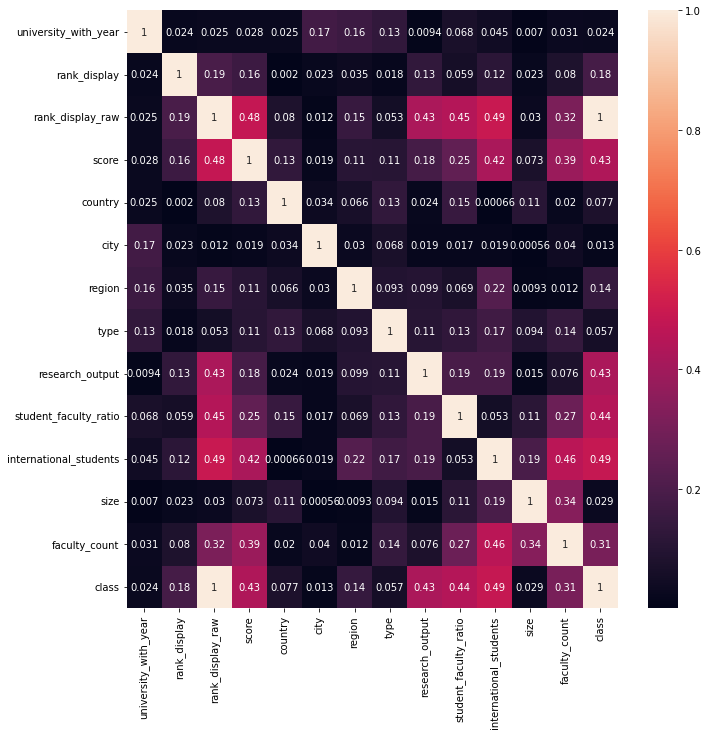

In [864]:
data_corr = data.drop(columns=["university", "year"], axis=1).corr()
plt.figure(figsize = (11,11))
sns.heatmap(abs(data_corr), annot = True)

### Decision Tree

In [865]:
data.dropna(subset=["class"], inplace=True)

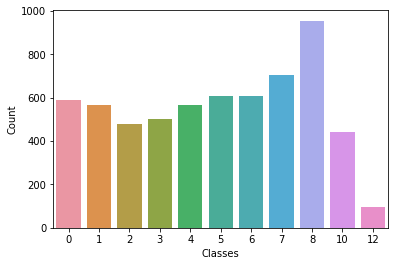

In [866]:
ax = sns.countplot(x="class", data=data)
ax.set_xticklabels(["0", "1", "2", "3", "4", "5", "6", "7", "8", "10", "12"])
plt.xlabel("Classes")
plt.ylabel("Count")
plt.show()


# plt.bar(data["class"].unique(), data["class"].value_counts())
# plt.xlabel("Classes")

#### Useful fonctions

In [867]:
def get_training_sets(data, target_label, test_size=0.2):
    return train_test_split(
        data.drop(labels=target_label, axis=1),
        data[target_label],
        test_size=test_size
    )


def clf_score(clf, test_x, test_y):

    pred_y = clf.predict(test_x).astype(int)

    d = {
        "accuracy": metrics.accuracy_score,
        "precision": lambda true, pred: metrics.precision_score(true, pred, average='micro'),
        "recall": lambda true, pred: metrics.recall_score(true, pred, average='micro'),
        "jaccard": lambda true, pred: metrics.jaccard_score(true, pred, average='micro'),
    }

    return {
        name: method(test_y, pred_y)
        for name, method in d.items()
    }


def reg_score(clf, test_x, test_y):

    pred_y = clf.predict(test_x)

    d = {
        "explained variance": metrics.explained_variance_score,
        "RMSE": metrics.mean_squared_error,
        "R2": metrics.r2_score
    }

    return {
        name: method(test_y, pred_y)
        for name, method in d.items()
    }    



#### Tree Classification

Scores:
  Accuracy: 0.62
  Precision: 0.62
  Recall: 0.62
  Jaccard: 0.44
Features importance:


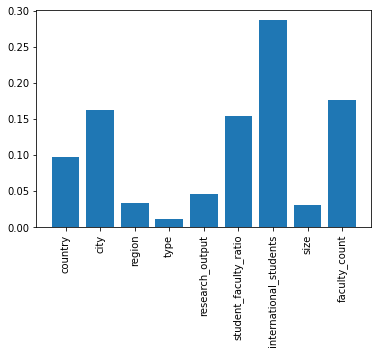

In [868]:


def show_tree_results(clf, test_x, test_y, with_graph=True):
    # Scores
    scores = clf_score(clf, test_x, test_y)
    print("Scores:")
    print("\n".join([
        f"  {name.capitalize()}: {score:0.2f}"
        for name, score in scores.items()
    ]))

    # Features importance
    print("Features importance:")
    plt.bar(clf.feature_names_in_, clf.feature_importances_)
    plt.xticks(rotation=90)
    plt.show()

    # Graph
    if with_graph:
        plt.figure(figsize=(20, 20))
        tree.plot_tree(clf, fontsize=6)
        plt.savefig('tree_results', dpi=100)
        

def decision_tree():
    not_feature_cols = [
        "university_with_year", "university", "year",
        "rank_display", "rank_display_raw", "score"
    ]

    tree_data = data.drop(labels=not_feature_cols, axis=1)
    train_x, test_x, train_y, test_y = get_training_sets(tree_data, "class")
    
    # Training
    tree_clf = tree.DecisionTreeClassifier()
    tree_clf.fit(train_x, train_y)
    
    # Results
    show_tree_results(tree_clf, test_x, test_y, with_graph=False)
    
decision_tree()

### Regression

#### Linear Model

Scores:
Classification:
  Accuracy: 0.15
  Precision: 0.15
  Recall: 0.15
  Jaccard: 0.08
Regression:
  Explained variance: 0.46
  Rmse: 5.47
  R2: 0.46
Features importance:


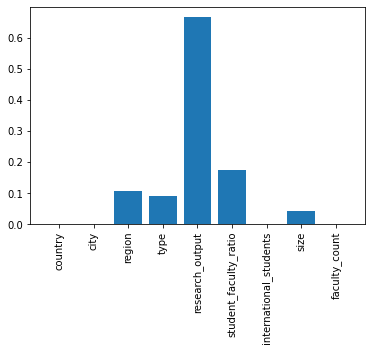

In [869]:
def show_lm_results(clf, test_x, test_y):
    # Scores
    reg_scores = reg_score(clf, test_x, test_y)
    clf_scores = clf_score(clf, test_x, test_y)

    print("Scores:")
    
    print("Classification:")
    print("\n".join([
        f"  {name.capitalize()}: {score:0.2f}"
        for name, score in clf_scores.items()
    ]))

    print("Regression:")
    print("\n".join([
        f"  {name.capitalize()}: {score:0.2f}"
        for name, score in reg_scores.items()
    ]))

    # Features importance
    print("Features importance:")
    plt.bar(clf.feature_names_in_, np.abs(clf.coef_))
    plt.xticks(rotation=90)
    plt.show()


scored_data = data.dropna()

def linear_model():
    not_feature_cols = [
        "university_with_year", "university", "year",
        "rank_display", "rank_display_raw", "score"
    ]

    lm_data = data.drop(labels=not_feature_cols, axis=1)
    train_x, test_x, train_y, test_y = get_training_sets(lm_data, "class")

    # Training
    lm_clf = LinearRegression()
    lm_clf.fit(train_x, train_y)

    # Results
    show_lm_results(lm_clf, test_x, test_y)

linear_model()

### XGBoost

#### Régression

Scores:
  Explained variance: 0.93
  Rmse: 28.98
  R2: 0.93
Features importance:


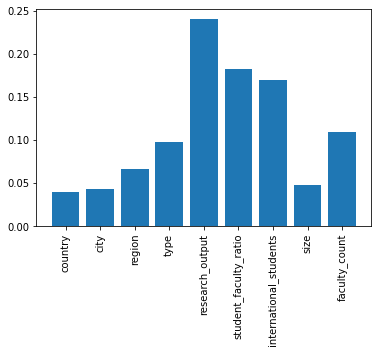

In [870]:
def show_score_xgreg_results(clf, test_x, test_y, features_names):
    # Scores
    reg_scores = reg_score(clf, test_x, test_y)

    print("Scores:")
    print("\n".join([
        f"  {name.capitalize()}: {score:0.2f}"
        for name, score in reg_scores.items()
    ]))

    # Features importance
    print("Features importance:")
    plt.bar(features_names, np.abs(clf.feature_importances_))
    plt.xticks(rotation=90)
    plt.show()
    
    
def score_xgregression():
    not_feature_cols = [
        "university_with_year", "university", "year",
        "rank_display", "rank_display_raw", "class"
    ]

    xgreg_data = data.drop(labels=not_feature_cols, axis=1)
    xgreg_data.dropna(inplace=True)

    train_x, test_x, train_y, test_y = get_training_sets(xgreg_data, "score")

    # Training
    xg_clf = XGBRegressor()
    xg_clf.fit(train_x, train_y)

    # Score
    show_score_xgreg_results(xg_clf, test_x, test_y, xgreg_data.drop(labels="score", axis=1).columns)

score_xgregression()
    
    

#### Classification

C:\Users\Josse\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:32:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Scores:
  Accuracy: 0.64
  Precision: 0.64
  Recall: 0.64
  Jaccard: 0.47
Features importance:


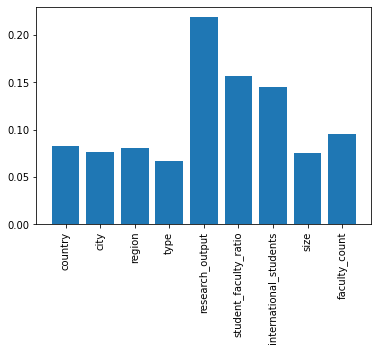

In [871]:
def show_rank_xgclf_results(clf, test_x, test_y, features_names):
    # Scores
    clf_scores = clf_score(clf, test_x, test_y)

    print("Scores:")
    print("\n".join([
        f"  {name.capitalize()}: {score:0.2f}"
        for name, score in clf_scores.items()
    ]))

    # Features importance
    print("Features importance:")
    plt.bar(features_names, np.abs(clf.feature_importances_))
    plt.xticks(rotation=90)
    plt.show()
    

def rank_xgclassification():
    not_feature_cols = [
        "university_with_year", "university", "year",
        "rank_display", "rank_display_raw", "score"
    ]

    xgreg_data = data.drop(labels=not_feature_cols, axis=1)
    xgreg_data.dropna(inplace=True)

    train_x, test_x, train_y, test_y = get_training_sets(xgreg_data, "class")

    # Training
    xg_clf = XGBClassifier()
    xg_clf.fit(train_x, train_y)

    # Score
    show_rank_xgclf_results(xg_clf, test_x, test_y, xgreg_data.drop(labels="class", axis=1).columns)

rank_xgclassification()
    
    